In [ ]:
!nvidia-smi

Mon May 16 12:24:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Main Libraries

In [ ]:
pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import datetime
import math
import itertools 
import pickle
import time
import os
import sys
import shutil
import keras
import glob
import cv2
import random
import textwrap
import scipy.ndimage as ndimage
import seaborn as sns

from sklearn.model_selection import train_test_split
from math import ceil, floor
from pathlib import Path
from tqdm import tqdm
from sklearn import metrics
from tqdm.notebook import tqdm
from IPython.display import clear_output
from PIL import Image, ImageDraw, ImageFont

# Setup Colab

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Unzip Datasets

In [ ]:
!ls "/content/drive/My Drive/ColabNotebooks/Datasets"
!unzip "/content/drive/My Drive/ColabNotebooks/Datasets/hyperkvasir-labelled-data.zip"
!unzip "/content/drive/MyDrive/ColabNotebooks/Datasets/hyper-kvasir-unlabeled-images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: unlabeled-images/images/f0ac75c5-aa3a-499c-9279-394c81c1e38e.jpg  
  inflating: unlabeled-images/images/f0ad3837-b02a-4063-915f-862b1b49af80.jpg  
  inflating: unlabeled-images/images/f0ae2c28-ea6a-4e06-b1d0-87901922743c.jpg  
  inflating: unlabeled-images/images/f0aea848-2421-4546-8aa8-2e50580a7448.jpg  
  inflating: unlabeled-images/images/f0b03d86-28f5-4781-9522-3eee03698e9d.jpg  
  inflating: unlabeled-images/images/f0b32acc-a6aa-42b0-b47f-10acdce147b8.jpg  
  inflating: unlabeled-images/images/f0b5b294-9646-4a56-bcdd-d02241567449.jpg  
  inflating: unlabeled-images/images/f0b6ade9-c4df-4eb7-9780-fc391bb7712f.jpg  
  inflating: unlabeled-images/images/f0b81110-0e2b-499a-b6c3-f2727938830a.jpg  
  inflating: unlabeled-images/images/f0ba2ceb-2c1a-4f7c-9faf-011c524ca64a.jpg  
  inflating: unlabeled-images/images/f0bc6960-648f-4f1e-b616-d414b4ed0c2f.jpg  
  inflating: unlabeled-images/images/f0bc6c34-7636-4251-85a7-a8926103

# Initialize

In [ ]:
labeled_data_root = pathlib.Path('/content/hyperkvasir-labelled-data')
unlab_data_root = pathlib.Path('/content/unlabeled-images')

# Primary directory
record_dir = "./records/{}".format("labelled_model")
pathlib.Path(record_dir).mkdir(parents=True, exist_ok=True) # record_directory

cache_dir = "./cache"
pathlib.Path(cache_dir).mkdir(parents=True, exist_ok=True) # cache directory

# Split Dataset

In [ ]:
# Split the dataset into train, test and validation splits
def split_dataset():

    # The seed() method is used to initialize the random number generator.
    random.seed(1500)
    
    # listdir() returns a list containing the names of the entries in the directory
    class_names = os.listdir(labeled_data_root)
    image_folders = [os.path.join(labeled_data_root, class_name) for class_name in class_names]
    
    num_samples = len(list(Path(labeled_data_root).glob('*/*')))

    # Create folders for each class under the train, test and val folders
    train_folders = [os.path.join('labeled_data', 'train', name) for name in class_names]
    test_folders = [os.path.join('labeled_data', 'test', name) for name in class_names]
    val_folders = [os.path.join('labeled_data', 'val', name) for name in class_names]

    for folder in train_folders:
      Path(folder).mkdir(parents=True, exist_ok=True)

    for folder in test_folders:
      Path(folder).mkdir(parents=True, exist_ok=True)
                              
    for folder in val_folders:
      Path(folder).mkdir(parents=True, exist_ok=True)

    # tqdm is the library which was used to create the Progress Bar
    tqdm_img = tqdm(total=num_samples, desc='Splitting Progress', position=0)

    # split all the classes equally to test, train and val
    for index, directory in enumerate(image_folders):

        random.seed(1500)
        imagenames = os.listdir(directory)
        imagenames.sort() # make sure that the image filenames have a fixed order before shuffling
        random.shuffle(imagenames) # shuffles the ordering of image filenames (deterministic given the chosen seed)
        num_samples = len(imagenames)

        # Here the dataset splits according to the given float values
        imagenames = np.array(imagenames)
        imagenames_split = np.split(imagenames, [floor(num_samples*float(0.7)), floor(num_samples*float(0.85))]) #Train: 70%| Test: 15% | Val: 15%
        
        dataset = {'train': imagenames_split[0],
                   'test': imagenames_split[1],
                   'val': imagenames_split[2]}

        for split in dataset:
            output = os.path.join('labeled_data', split, directory.split("/")[-1])
            for filename in dataset[split]:
                filename = os.path.join(directory, filename)
                image_resize(filename, output) # Resize the image to 128, 128 dimensions
                tqdm_img.update(1) #Updates the Progress Bar

In [ ]:
# Method used to resize the image to 128 size
def image_resize(filename, output_dir):
    image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LINEAR)
    path = os.path.join(output_dir, filename.split('/')[-1])
    cv2.imwrite(path, image) # Save the image in the output directory

In [ ]:
split_dataset()

Splitting Progress:   0%|          | 0/10662 [00:00<?, ?it/s]

In [ ]:
BATCH_SIZE = 8 # Hyperparameter
CLASS_NAMES = None
NUMBER_CLASSES = 0
DATASET_SIZE_TRAIN = None
DATASET_SIZE_TEST = None
DATASET_SIZE_VAL = None
DATASET_SIZE_UNLAB = None
STEPS_TRAIN = None
STEPS_TEST = None
STEPS_VAL = None
RAW_TRAIN_DATASET = None
AUTOTUNE = tf.data.experimental.AUTOTUNE

# function to load input image, preprocess it and get label
def load_label_images(image_path):
    # read the image from database, decode it, convert the data type to
	  # floating point, and then resize it
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])

    # parse the class label from the file path
    str_targets = tf.strings.split(image_path, os.path.sep)[-2]
    label_integer = tf.reduce_min(tf.where(tf.equal(str_targets, CLASS_NAMES)))
    label = tf.dtypes.cast(label_integer, tf.int32)

    return image, label

# Method used to organize the datasets, making it suitable to train
def build_datasets():

    global CLASS_NAMES
    global NUMBER_CLASSES
    global DATASET_SIZE_TRAIN
    global DATASET_SIZE_TEST
    global DATASET_SIZE_VAL
    global STEPS_TRAIN
    global STEPS_TEST
    global STEPS_VAL
    global RAW_TRAIN_DATASET

    labeled_data_root = pathlib.Path('/content/labeled_data')
    np.random.seed(seed=1500)

    class_names = np.array([item.name for item in labeled_data_root.glob('train/*')])

    CLASS_NAMES = class_names
    NUMBER_CLASSES = len(class_names)

    model_class_names = list(class_names)
    handle = open(record_dir+"/model_class_names.pkl", 'wb')
    pickle.dump(model_class_names, handle)
    
    dataset = {'train': str(labeled_data_root/'train'/'*/*.*g'),
          'test': str(labeled_data_root/'test'/'*/*.*g'),
          'val': str(labeled_data_root/'val'/'*/*.*g')}

    DATASET_SIZE_TRAIN = len(list(glob.glob(dataset["train"])))
    DATASET_SIZE_TEST = len(list(glob.glob(dataset["test"])))
    DATASET_SIZE_VAL = len(list(glob.glob(dataset["val"])))
    
    for split in dataset:
        dataset[split] = tf.data.Dataset.list_files(dataset[split],
                                    shuffle=True,
                                    seed=tf.constant(1500, tf.int64)
                                    )
    
    # Map labels with the images from tf.dataset to create "train", "test", "val" datasets
    for split in dataset:
        dataset[split] = dataset[split].map(load_label_images, num_parallel_calls=AUTOTUNE)
    
    RAW_TRAIN_DATASET = dataset["train"] # Clean dataset of the "train" split
    
    print("[INFO] loading the dataset...")

    # training dataset split will go through a resample, suffle, repeat, data augment,
    # and prefetched phase
    dataset["train"] = resample(dataset["train"])
    dataset["train"] = (
      dataset["train"]
      .shuffle(buffer_size=3000, seed=tf.constant(1500, tf.int64))
      .repeat()
      .map(dataset_augmentation(), num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE, drop_remainder=False)
      .prefetch(buffer_size=AUTOTUNE)
    )

    # testing dataset split will go through a caching, suffle, repeat,
    # and prefetched phase
    cache_string = "{}/{}_{}".format(cache_dir, 128, "test")
    dataset["test"] = (
      dataset["test"]
      .cache(cache_string)
      .shuffle(buffer_size=3000, seed=tf.constant(1500, tf.int64))
      .repeat()
      .batch(BATCH_SIZE, drop_remainder=False)
      .prefetch(buffer_size=AUTOTUNE)
    )

    # testing dataset split will go through a caching, suffle, repeat,
    # and prefetched phase
    cache_string = "{}/{}_{}".format(cache_dir, 128, "val")
    dataset["val"] = (
      dataset["val"]
      .cache(cache_string)
      .shuffle(buffer_size=3000, seed=tf.constant(1500, tf.int64))
      .repeat()
      .batch(BATCH_SIZE, drop_remainder=False)
      .prefetch(buffer_size=AUTOTUNE)
    )

    print("[INFO] train, test and val datasets created")

    STEPS_TRAIN = DATASET_SIZE_TRAIN//BATCH_SIZE
    STEPS_TEST = DATASET_SIZE_TEST//BATCH_SIZE
    STEPS_VAL = DATASET_SIZE_VAL//BATCH_SIZE
    
    return dataset

In [ ]:
# Method used to count the sample count in a class
def count_class_samples(dataset, num_classes):
    count = np.zeros(num_classes) # returns a new array with zeros according to the class count
    for img, lab in dataset:
        count[lab] += 1
    return count

Resample Dataset

In [ ]:
# Method used to resample the dataset. This is a solution of highly imbalanced problem
def resample(dataset):

    datasets = []
    cache_dir = './cache/{}_resampled_{}/'.format(128, 'train')
    pathlib.Path(cache_dir).mkdir(parents=True, exist_ok=True) # create cache directory
    
    for i in range(NUMBER_CLASSES): # NUMBER_CLASSES = 23
        data = dataset.filter(lambda img, lab: lab==i)
        data = data.cache(cache_dir+'{}_dataset'.format(i))
        
        data = data.repeat()
        datasets.append(data)
    
    target_dist = [ 1.0/NUMBER_CLASSES ] * NUMBER_CLASSES
    # samples elements from the datasets in the array datasets at randomly
    balanced_dataset = tf.data.experimental.sample_from_datasets(datasets, weights=target_dist, seed=1500)
    
    return balanced_dataset

Data Augmentation

In [ ]:
# Method to image augment the dataset
def dataset_augmentation():

    tf.random.set_seed(1500) # global seed
    
    def image_augment(image, label):

        degree = tf.random.normal([])*360
        image = tfa.image.rotate(image, degree * math.pi / 180, interpolation='BILINEAR')
        image = tf.image.resize_with_crop_or_pad(image, 138, 138)
        image = tf.image.random_crop(image, (128, 128, 3), seed=1500)
        image = tf.image.random_brightness(image, max_delta=0.2, seed=1500)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=1500)
        image = tf.image.random_hue(image, max_delta=0.2, seed=1500)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5, seed=1500)
        image = tf.image.random_flip_left_right(image, seed=1500)
        image = tf.image.random_flip_up_down(image, seed=1500)

        # The random_* ops do not necessarily clamp.
        # Here it clip tensors value to min 0 and max 1
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image, label
    
    return image_augment

In [ ]:
dataset = build_datasets()

[INFO] loading the dataset...
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
[INFO] train, test and val datasets created


# Load unlabelled dataset

In [ ]:
# Method to load the unlabelled data
def load_unlab_images(image_path):
    # read the image from database, decode it, convert the data type to
	  # floating point, and then resize it
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])

    # obtain filename
    filename = tf.strings.split(image_path, os.path.sep)[-1]
    return image, filename

def create_unlab_dataset():

  global DATASET_SIZE_UNLAB

  unlab_data_root = pathlib.Path('/content/unlabeled-images/images')

  DATASET_SIZE_UNLAB = len(list(unlab_data_root.glob('*.*g')))

  files_string = str(unlab_data_root/'*.*g')
  list_dataset_unlabeled = tf.data.Dataset.list_files(
          files_string, 
          shuffle=True, 
          seed=tf.constant(1500, tf.int64)
  )
  
  unlab_dataset = list_dataset_unlabeled.map(load_unlab_images, num_parallel_calls=AUTOTUNE)

  print ("Loaded {} images into unlabeled_dataset.".format(DATASET_SIZE_UNLAB))
  
  return unlab_dataset

In [ ]:
dataset["unlab"] = create_unlab_dataset()

Loaded 99417 images into unlabeled_dataset.


# Define the Hybrid Ensemble model used for labelled data

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPool2D, Multiply, Concatenate, Input, Dropout, ZeroPadding2D, Flatten
from tensorflow.keras import backend as K
from keras.layers import concatenate

datasets_bin = [count_class_samples( RAW_TRAIN_DATASET, NUMBER_CLASSES)]
dataset["mix_train"] = RAW_TRAIN_DATASET

# Method to define all the algorithms used for the architecture
def define_all_models():
    all_models = list()

    inputs = Input(batch_shape=(None, None, None, 3))

    base_model1 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(128, 128, 3),
        input_tensor=inputs
    )

    all_models.append(base_model1)

    base_model2 = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(128, 128, 3),
        input_tensor=inputs
    )

    all_models.append(base_model2)
    return all_models, inputs

# Create the final architecture
def model_define():

    models, inputs = define_all_models()

    for i in range(len(models)):
      model = models[i]
      for layer in model.layers:
        layer._name = 'ensemble_' + layer.name + str('_model_') + str(i + 1)
    
    print(models[0].output.shape)
    print(models[1].output.shape)

    out1 = models[0].output
    out1 = ZeroPadding2D(((0,2), (0,2)))(out1) # Zero-padding layer for 2D input 
    
    outputs = concatenate([out1, models[1].output])

    # used for global average pooling operation for spatial data.
    z = GlobalAveragePooling2D()(outputs) 
    z = Flatten()(z) # newly added
    z = Dropout(0.3)(z)  # to prevent overfitting
    z = Dense(28, activation='relu')(z) # relu to overcome gradient decent problem 
    z = Dense(3584, activation='sigmoid')(z)
    z = Multiply()([outputs, z])
    z = GlobalAveragePooling2D()(z)
    z = Dense(NUMBER_CLASSES, activation="softmax")(z) # "Softmax" Activation layer for classification

    model = Model(inputs=inputs, outputs=z) 

    # plot_model(model, show_shapes=True, to_file='ensemble_models.png')
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), # Good with sparse data
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()
    
    return model


In [ ]:
model = model_define()

94781440/94765736 [==============================] - 1s 0us/step
(None, None, None, 1536)
(None, None, None, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ensemble_ensemble_input_1_mode  [(None, None, None,  0          []                               
 l_1_model_2 (InputLayer)        3)]                                                              
                                                                                                  
 ensemble_conv2d_model_1 (Conv2  (None, None, None,   864        ['ensemble_ensemble_input_1_model
 D)                             32)                              _1_model_2[0][0]']               
                                                                                                  
 ensemble_batch_normalization_m  (None, None, None,   96         ['ensemble_co

# Train the model for labelled data

In [ ]:
start = time.time()

model_train = model.fit(
        dataset["train"],
        steps_per_epoch = STEPS_TRAIN,
        epochs = 15,
        validation_data = dataset["val"],
        validation_steps = STEPS_VAL,
        validation_freq = 1,
        verbose = 1
)

print ("Total time:", (np.round(time.time() - start, 4)/60), "minutes.")

Epoch 1/15
931/931 [==============================] - 258s 194ms/step - loss: 1.9230 - sparse_categorical_accuracy: 0.3476 - val_loss: 1.7339 - val_sparse_categorical_accuracy: 0.4608
Epoch 2/15
931/931 [==============================] - 174s 187ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.5537 - val_loss: 1.2230 - val_sparse_categorical_accuracy: 0.6262
Epoch 3/15
931/931 [==============================] - 159s 171ms/step - loss: 0.9825 - sparse_categorical_accuracy: 0.6496 - val_loss: 1.0857 - val_sparse_categorical_accuracy: 0.6654
Epoch 4/15
931/931 [==============================] - 160s 171ms/step - loss: 0.8745 - sparse_categorical_accuracy: 0.6869 - val_loss: 1.9848 - val_sparse_categorical_accuracy: 0.6088
Epoch 5/15
931/931 [==============================] - 158s 170ms/step - loss: 0.7490 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.7676 - val_sparse_categorical_accuracy: 0.7637
Epoch 6/15
931/931 [==============================] - 155s 167ms/step - loss: 0.

In [ ]:
print(model_train.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


In [ ]:
def save_model():
  handle = open(record_dir+"/model_train.pkl", 'wb')
  pickle.dump(model_train.history, handle)
  model.save(record_dir+'/model.h5')

## Model Evaluation

In [ ]:
def calculate_true_and_predicted_cat(model, dataset):

  # Using test data to evaluate the model
  test_evaluate = model.evaluate(dataset["test"], steps=STEPS_TEST) # steps since tf.dataset
  print("\nTest Accuracy: ", test_evaluate)

  # Find true_categories and predicted_categories
  eval_dataset = dataset["test"].unbatch().take(DATASET_SIZE_TEST)
  eval_dataset = eval_dataset.as_numpy_iterator()
  eval_dataset = np.array(list(eval_dataset))
  true_categories = list(eval_dataset[:,1]) 
  eval_images = np.stack(eval_dataset[:,0], axis=0) # eval_dataset[:,0] = give me the 0th index of all the rows in eval_dataset

  # Create predictions and predicted_categories
  predictions = model.predict(eval_images)
  predicted_categories = [np.argmax(pred) for pred in predictions]

  return true_categories, predicted_categories

def using_evaluation_metrics(model_train, true_categories, predicted_categories):

    sns.set()
    
    # Plot Accuracy
    plot_accuracy(model_train)
    # Plot Loss
    plot_loss(model_train)

    print('\nAccuracy score is :', metrics.accuracy_score(true_categories, predicted_categories))
    print('Precision score is :', metrics.precision_score(true_categories, predicted_categories, average='weighted'))
    print('Recall score is :',metrics.recall_score(true_categories, predicted_categories, average='weighted'))
    print('F1 Score is :', metrics.f1_score(true_categories, predicted_categories,average='weighted'))
    print('Cohen Kappa Score :', metrics.cohen_kappa_score(true_categories, predicted_categories))
    print("MCC :", metrics.matthews_corrcoef(true_categories, predicted_categories))
    
    # Print the Classification report
    print("\nClassification Report: ")
    report = metrics.classification_report( y_true=true_categories, y_pred=predicted_categories,
                labels=range(NUMBER_CLASSES),
                target_names=CLASS_NAMES,
                digits=3,
                zero_division=0)
    print(report)

def plot_confusion_matrix(cm, names=None):

    print('Confusion Matrix')
    
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()

    tick_marks = np.arange(NUMBER_CLASSES)
    plt.xticks(tick_marks, CLASS_NAMES, rotation=90)
    plt.yticks(tick_marks, CLASS_NAMES)

    # normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Categories')
    plt.xlabel('Predicted Categories')
    plt.savefig(record_dir+"/confusion_matrix.pdf", format="pdf")
    plt.show()

def plot_accuracy(model_train):
  
  plt.plot(model_train.history['sparse_categorical_accuracy'], label='Training Accuracy')
  plt.plot(model_train.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()

def plot_loss(model_train):
  plt.plot(model_train.history['loss'], label='Training Loss')
  plt.plot(model_train.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()

199/199 [==============================] - 11s 49ms/step - loss: 0.7129 - sparse_categorical_accuracy: 0.7883

Test Accuracy:  [0.7128790616989136, 0.7883166074752808]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


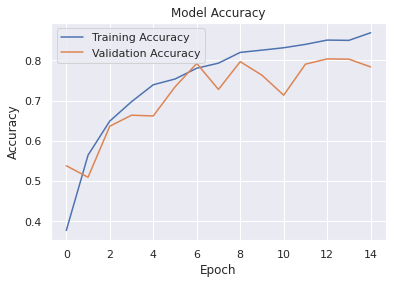

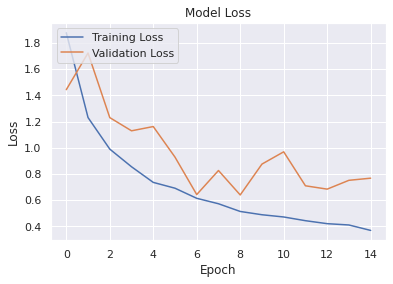


Accuracy score is : 0.7878598247809763
Precision score is : 0.8103591220779168
Recall score is : 0.7878598247809763
F1 Score is : 0.782139212383037
Cohen Kappa Score : 0.7701205322361352
MCC : 0.7719373703041781

Classification Report: 
                              precision    recall  f1-score   support

                      z-line      0.718     0.800     0.757       140
                       cecum      0.836     0.980     0.902       151
            retroflex-rectum      0.587     0.915     0.715        59
                       ileum      0.000     0.000     0.000         1
                    barretts      0.000     0.000     0.000         6
               esophagitis-a      0.407     0.400     0.403        60
      dyed-resection-margins      1.000     0.500     0.667       148
              impacted-stool      0.556     1.000     0.714        20
ulcerative-colitis-grade-1-2      0.000     0.000     0.000         2
  ulcerative-colitis-grade-2      0.477     0.318     0.382  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


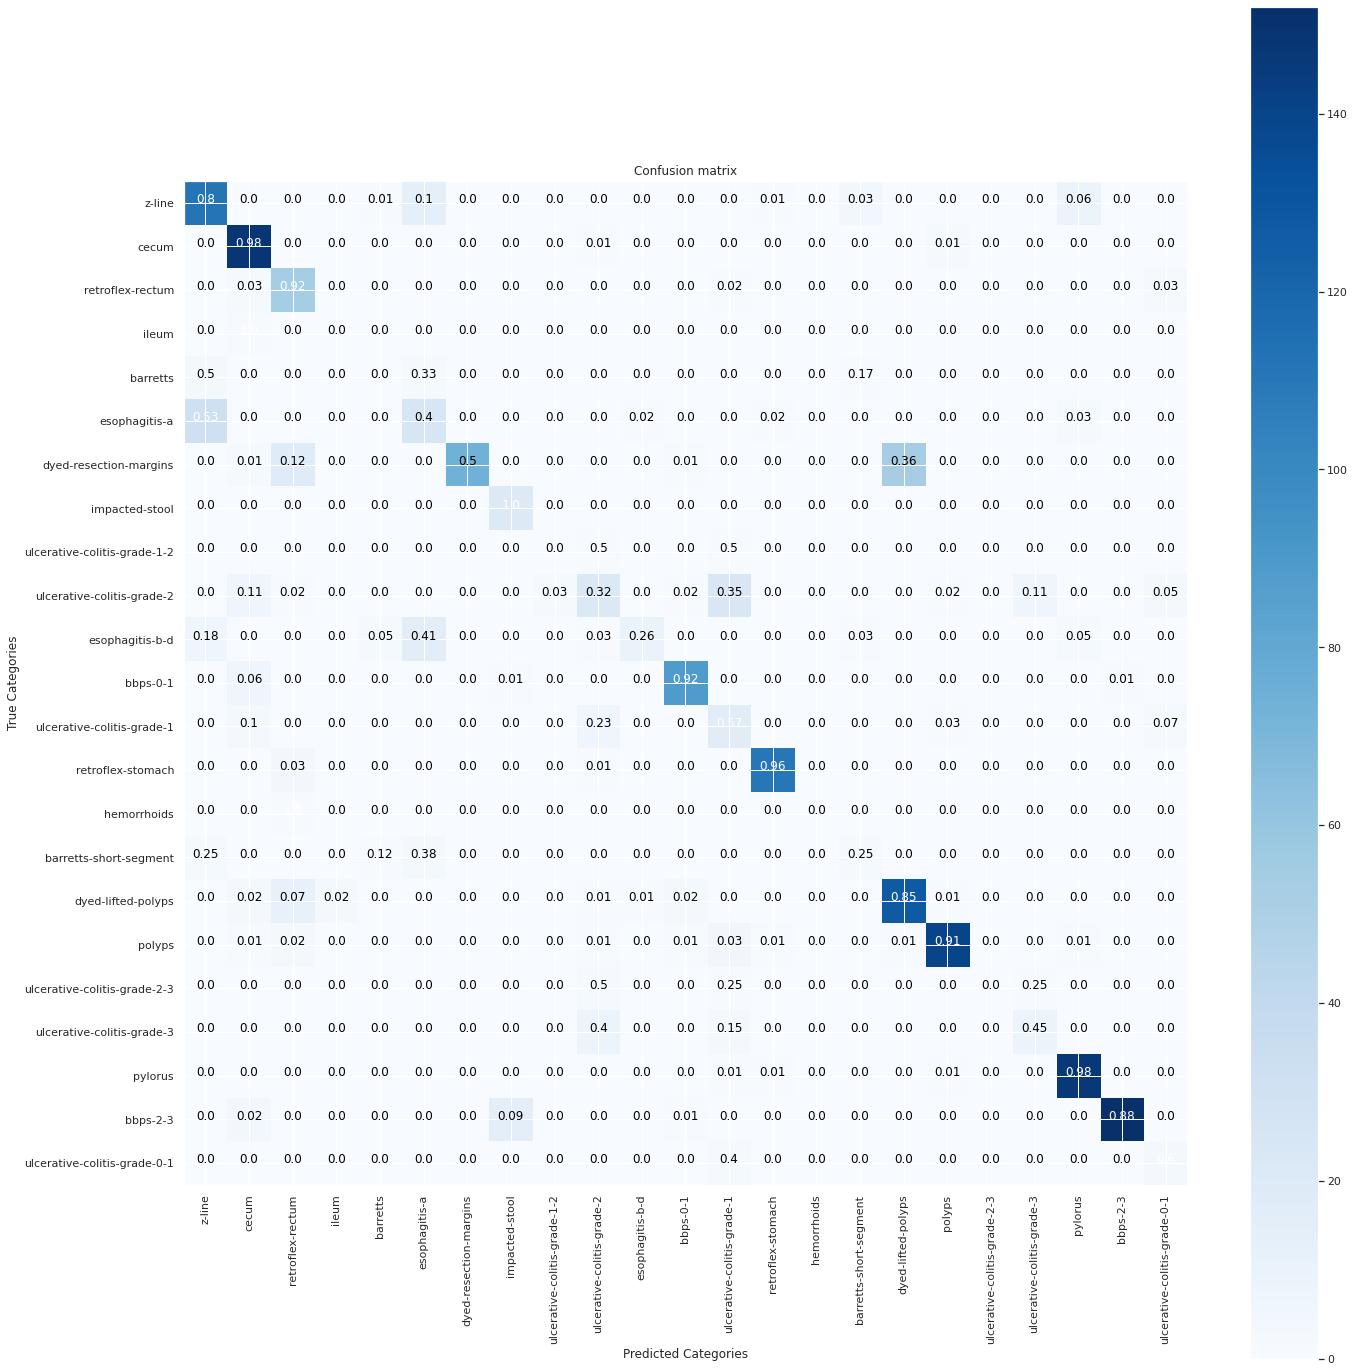

In [ ]:
true_categories, predicted_categories = calculate_true_and_predicted_cat(model, dataset)
using_evaluation_metrics(model_train, true_categories, predicted_categories)

# Plot the Confusion Matrix
cm = metrics.confusion_matrix(true_categories, predicted_categories)
plot_confusion_matrix(cm, CLASS_NAMES)

save_model()

# Generate pseudo labels on unlabeled images using the previously built model

### Generate pseudo labels for the unlabelled dataset

In [ ]:
findings = {
    "prediction_value_list": [], 
    "label_index_list": [], 
    "img_name_list": []
    }

In [ ]:
def generate_pseudo_labels(unlab_dataset, model):

    # Use the unlabeled dataset to generate new psuedo labels
    start = time.time()
    findings_count = 0

    # Show tqdm bars
    predicting_bar = tqdm(total=DATASET_SIZE_UNLAB, desc='Predicting', position=0, initial=0)
    findings_bar = tqdm(total=DATASET_SIZE_UNLAB, desc='Findings', position=1, bar_format='{desc}:{bar}{n_fmt}', initial=0)
    
    # Iterates the images one by one
    for tot_cnt, (image,path) in enumerate(unlab_dataset, start=0):
      if tot_cnt > 20000:
          break
              
      img = np.expand_dims(image, 0)
      prediction = model.predict(img) # returns numpy array(s) of predictions.
      highest_pred = np.max(prediction) # returns the maximum value

      # Check if the highest_pred is more than the threshold value
      if highest_pred > 0.85:
          prediction_index = np.argmax(prediction).astype(np.uint8) # returns the index of the max element

          findings["label_index_list"].append(prediction_index)
          findings["prediction_value_list"].append(highest_pred)
          findings["img_name_list"].append(path)
              
          findings_count += 1
          findings_bar.update(1)
      predicting_bar.update(1)

    # Save the pseudo labels
    handle = open(record_dir+"/pseudo_labels.pkl", 'wb')
    pickle.dump(findings, handle)
        
    print ("\nTotal run time: {:.1f} min.".format( (time.time() - start)/60 ))
    print ("Found {} new samples in unlabeled_dataset after looking at {} images.".format(findings_count, tot_cnt))
        
    return findings

In [ ]:
findings = generate_pseudo_labels(dataset["unlab"], model)

Predicting:   0%|          | 0/99417 [00:00<?, ?it/s]

Findings:          0


Total run time: 31.4 min.
Found 9097 new samples in unlabeled_ds after looking at 20001 images.


### Sort the lists from confidence levels highest to lowest



In [ ]:
sorted_list = list(zip(findings["prediction_value_list"], findings["label_index_list"], findings["img_name_list"]))
sorted_list.sort(key=lambda x: x[0], reverse=True)

pred_sorted = [row[0] for row in sorted_list]
lab_sorted = [row[1] for row in sorted_list]
name_sorted = [row[2] for row in sorted_list]

pseudo_sorted = {
    "prediction_value_list": pred_sorted,
    "label_index_list": lab_sorted,
    "img_name_list": name_sorted
}

### Create new dataset by combining train data and new findings

In [ ]:
unlab_data_root = pathlib.Path('/content/unlabeled-images/images')

In [ ]:
def create_new_dataset(dataset, pseudo_sorted, datasets_bin):

  new_findings, added_samples = resample_new_dataset(pseudo_sorted, datasets_bin[-1])

  # create a Dataset whose elements are slices of the new findings
  findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)
  dataset["mix_train"] = dataset["mix_train"].concatenate(findings_tensor) # Combine the train dataset with new findings

  # count class samples of the combined dataset
  datasets_bin.append(count_class_samples(dataset["mix_train"], NUMBER_CLASSES))

  return datasets_bin, added_samples

def read_unlab_images(tensor, folder):
    # function to read unlabelled images
    
    tensor = tensor.numpy().decode("utf-8")
    image = tf.io.read_file("{}/{}".format(folder, tensor))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image

# This is done because images should be added to classes equally without adding hundreds of images to
# one class, and nothing for another
def resample_new_dataset(pseudo, initial_class_distrib):

    # Add the new findings to respective classes
    added = {}
    newly_added_total = 0
        
    print ('Resample')
    print ("-"*50)

    latest_additions = ([], [])
    latest_additions_filepaths = []

    # Convert the input to an array.
    label_array = np.asarray(pseudo["label_index_list"], dtype=np.uint8) 

    for class_index in range(NUMBER_CLASSES):

        # check the number of samples currently in the class
        sample_count = initial_class_distrib[class_index]

        indexes = np.where(label_array == class_index)[0]
        num_latest_additions = len(indexes)

        count = 0
        for count, i in enumerate(indexes, start=1):
            if sample_count >= 1000:
                count -= 1 # one count should be reduced as it is already added using enumerate()
                break
            tensor = pseudo["img_name_list"][i]
            image = read_unlab_images(tensor, unlab_data_root)
            
            # append the images
            latest_additions[0].append(image)  
            # append the labels of the images                        
            latest_additions[1].append(pseudo["label_index_list"][i])     
            # append the filepaths of the images     
            latest_additions_filepaths.append(pseudo["img_name_list"][i])
            sample_count += 1
            
        newly_added_total += count

        print ("{:30}: newly added {} samples out of {} samples".format(CLASS_NAMES[class_index], count, num_latest_additions))
            
        added[CLASS_NAMES[class_index]] = [count, num_latest_additions]
    
    print ("-"*50)
    print ("Total number of {} samples was added to the training dataset".format(newly_added_total))
        
    return latest_additions, latest_additions_filepaths

In [ ]:
datasets_bin, added_samples = create_new_dataset(dataset, pseudo_sorted, datasets_bin)

original_unlab_size = DATASET_SIZE_UNLAB
new_unlab_size = DATASET_SIZE_UNLAB - len(added_samples)
original_train_size = int(np.sum(datasets_bin[-2]))
new_train_size = int(np.sum(datasets_bin[-1]))

print("\nFinal Dataset Details:")
print("Newly added Samples: ", len(added_samples))
print("Unlabelled dataset size changed from {} to {} samples".format(original_unlab_size, new_unlab_size))
print("Labelled dataset size changed from {} to {} samples".format(original_train_size, new_train_size))

# Update dataset sizes
DATASET_SIZE_UNLAB -= len(added_samples)
DATASET_SIZE_TRAIN = new_train_size
STEPS_TRAIN = new_train_size//BATCH_SIZE 

Resample
--------------------------------------------------
retroflex-stomach          : added 0/862 samples
esophagitis-b-d            : added 81/81 samples
ulcerative-colitis-grade-1-2: added 0/0 samples
z-line                     : added 37/37 samples
barretts-short-segment     : added 106/106 samples
ileum                      : added 65/65 samples
retroflex-rectum           : added 91/91 samples
barretts                   : added 46/46 samples
ulcerative-colitis-grade-2-3: added 18/18 samples
ulcerative-colitis-grade-0-1: added 181/181 samples
bbps-0-1                   : added 13/13 samples
ulcerative-colitis-grade-2 : added 0/706 samples
polyps                     : added 0/2510 samples
dyed-resection-margins     : added 136/136 samples
impacted-stool             : added 0/0 samples
ulcerative-colitis-grade-1 : added 38/38 samples
cecum                      : added 0/1056 samples
ulcerative-colitis-grade-3 : added 80/80 samples
hemorrhoids                : added 1/1 samples
bbps

##Use the new dataset to train a pseudo model

In [ ]:
# Pseudo directory
record_dir = "./records/{}".format("pseudo_model")
pathlib.Path(record_dir).mkdir(parents=True, exist_ok=True) # record_directory

dataset["train"] = resample(dataset["mix_train"], NUMBER_CLASSES)
dataset["train"] = (
  dataset["train"]
  .shuffle(buffer_size=3000, seed=tf.constant(1500, tf.int64))
  .repeat()
  .map(dataset_augmentation(), num_parallel_calls=AUTOTUNE)
  .batch(BATCH_SIZE, drop_remainder=False)
  .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
new_model = model_define()

(None, None, None, 1536)
(None, None, None, 2048)
3584
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2_0_1 (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_203_0 (Conv2D)          (None, None, None,   864         ['input_2_0_1[0][0]']            
                                32)                                                               
                                                                                                  
 batch_normalization_203_0 (Bat  (None, None, None,   96         ['conv2d_203_0[0][0]']           
 chNormalization)               32)  

In [ ]:
start_time = time.time()

model_train = model.fit(
    dataset["train"],
    steps_per_epoch = STEPS_TRAIN, 
    epochs = 15,
    validation_data = dataset["val"],
    validation_steps = STEPS_VAL,
    validation_freq = 1,
    verbose = 1
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Epoch 1/15
1332/1332 [==============================] - 231s 166ms/step - loss: 0.3713 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.7447 - val_sparse_categorical_accuracy: 0.7873
Epoch 2/15
1332/1332 [==============================] - 221s 166ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.8862 - val_sparse_categorical_accuracy: 0.7973
Epoch 3/15
1332/1332 [==============================] - 220s 165ms/step - loss: 0.3392 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.8066
Epoch 4/15
1332/1332 [==============================] - 219s 164ms/step - loss: 0.3192 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.7895 - val_sparse_categorical_accuracy: 0.7954
Epoch 5/15
1332/1332 [==============================] - 219s 165ms/step - loss: 0.2889 - sparse_categorical_accuracy: 0.8949 - val_loss: 0.7246 - val_sparse_categorical_accuracy: 0.8103
Epoch 6/15
1332/1332 [==============================] - 219s 164ms/ste

### Model Evaluation

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks (1)/Experiments/InceptionResNetV2+ResNet50/Exp1

/content/drive/MyDrive/Colab Notebooks (1)/Experiments/InceptionResNetV2+ResNet50/Exp1


In [ ]:
model.save('hyperkvasir_InceptionResNetV2+ResNet50_student.h5')

In [ ]:
cd /content

/content


199/199 [==============================] - 11s 50ms/step - loss: 0.6975 - sparse_categorical_accuracy: 0.8398

Test Accuracy:  [0.6974593997001648, 0.8398241400718689]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


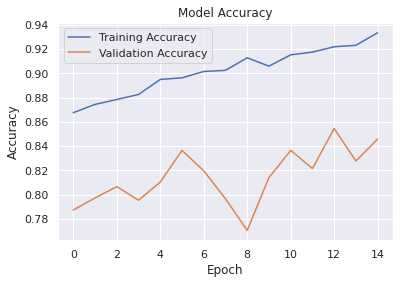

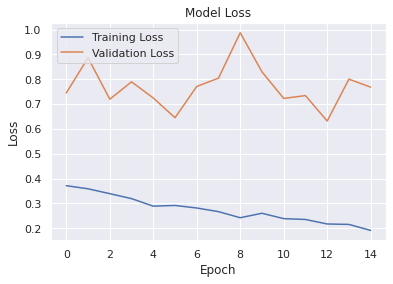


Accuracy score is : 0.8391739674593242
Precision score is : 0.8443350526175584
Recall score is : 0.8391739674593242
F1 Score is : 0.8367300083795888
Cohen Kappa Score : 0.8254863241968676
MCC : 0.8260921453545367

Classification Report: 
                              precision    recall  f1-score   support

           retroflex-stomach      0.884     0.991     0.934       115
             esophagitis-b-d      0.564     0.564     0.564        39
ulcerative-colitis-grade-1-2      0.000     0.000     0.000         2
                      z-line      0.744     0.850     0.793       140
      barretts-short-segment      0.125     0.125     0.125         8
                       ileum      0.000     0.000     0.000         1
            retroflex-rectum      0.979     0.797     0.879        59
                    barretts      1.000     0.167     0.286         6
ulcerative-colitis-grade-2-3      0.000     0.000     0.000         4
ulcerative-colitis-grade-0-1      0.167     0.200     0.182 

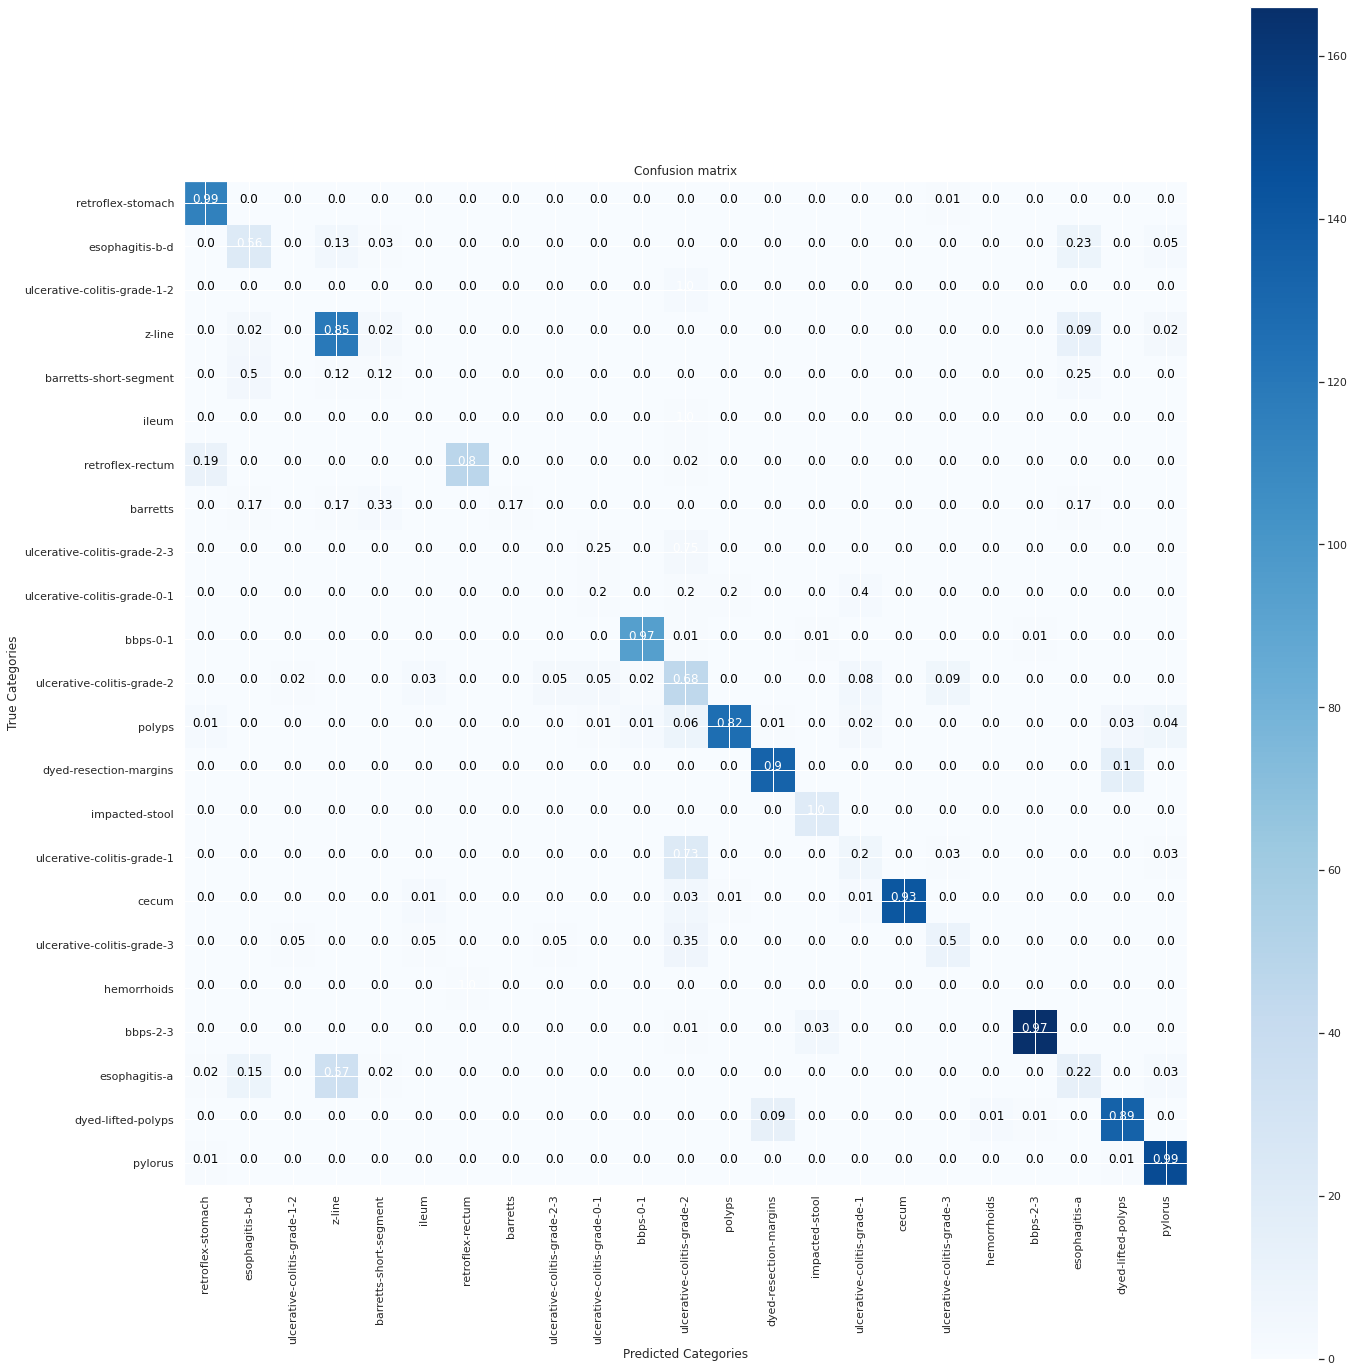

In [ ]:
true_categories, predicted_categories = calculate_true_and_predicted_cat(model, dataset)
using_evaluation_metrics(model_train, true_categories, predicted_categories)

# Plot the Confusion Matrix
cm = metrics.confusion_matrix(true_categories, predicted_categories)
plot_confusion_matrix(cm, CLASS_NAMES)